## h2oGPTe

In [77]:
from dotenv import load_dotenv
import os
import json
from IPython.display import Image

from h2ogpte import H2OGPTE

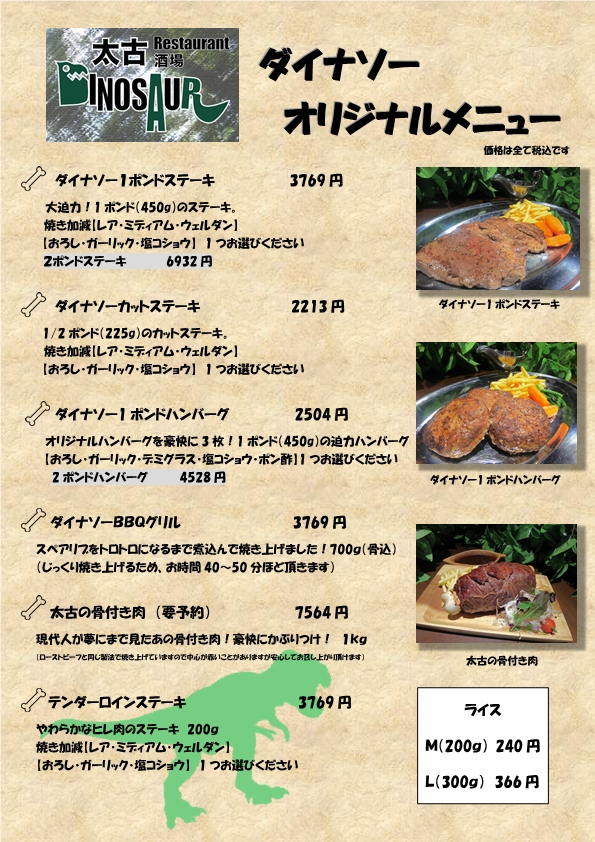

In [21]:
upload_file = 'menu1.jpg'
upload_file_path = os.path.join('menu_images', upload_file)

Image(upload_file_path)

In [7]:
load_dotenv(dotenv_path='.env')
heogpte_key = os.getenv('H2OGPTE_GLOBAL_KEY')
if heogpte_key: print('key is set.')

key is set.


In [8]:
client = H2OGPTE(
    address='https://h2ogpte.dev.h2o.ai',
    api_key=heogpte_key,
)
client

In [9]:
# 利用可能なEmbedding Model
client.list_embedding_models()

['BAAI/bge-large-en-v1.5', 'BAAI/bge-m3', 'hkunlp/instructor-large', 'off']

In [57]:
# 利用可能なLLM
client.get_llm_names()

['meta-llama/Meta-Llama-3.1-8B-Instruct',
 'h2oai/h2o-danube3-4b-chat',
 'Qwen/Qwen2-VL-7B-Instruct',
 'meta-llama/Meta-Llama-3.1-70B-Instruct',
 'meta-llama/Meta-Llama-3.1-405B-Instruct-FP8',
 'Qwen/Qwen2.5-72B-Instruct',
 'Qwen/Qwen2-VL-72B-Instruct',
 'h2oai/h2ovl-mississippi-2b',
 'mistralai/Pixtral-12B-2409',
 'mistralai/Mixtral-8x7B-Instruct-v0.1',
 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
 'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo',
 'upstage/SOLAR-10.7B-Instruct-v1.0',
 'mistralai/Mistral-7B-Instruct-v0.3',
 'meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo',
 'meta-llama/Llama-3.2-11B-Vision-Instruct-Turbo',
 'meta-llama/Llama-3.2-3B-Instruct-Turbo',
 'claude-3-haiku-20240307',
 'claude-3-5-haiku-20241022',
 'claude-3-5-sonnet-20241022',
 'gpt-4o',
 'gpt-4o-mini',
 'mistral-tiny',
 'mistral-small-latest',
 'mistral-medium-latest',
 'mistral-large-latest',
 'gemini-1.5-pro-latest',
 'gemini-1.5-flash-latest']

In [11]:
# 利用可能なVision Model
client.get_vision_capable_llm_names()

['auto',
 'Qwen/Qwen2-VL-7B-Instruct',
 'Qwen/Qwen2-VL-72B-Instruct',
 'h2oai/h2ovl-mississippi-2b',
 'mistralai/Pixtral-12B-2409',
 'meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo',
 'meta-llama/Llama-3.2-11B-Vision-Instruct-Turbo',
 'claude-3-haiku-20240307',
 'claude-3-5-haiku-20241022',
 'claude-3-5-sonnet-20241022',
 'gpt-4o',
 'gpt-4o-mini',
 'gemini-1.5-pro-latest',
 'gemini-1.5-flash-latest']

In [30]:
# 直近のコレクション
client.list_recent_collections(offset=0, limit=1)

[CollectionInfo(id='51813ac5-52ce-4466-9073-fc55172cc49d', name='menue_extraction', description='extracting each menue from a restaurant menue', document_count=1, document_size=1499449, updated_at=datetime.datetime(2025, 1, 11, 0, 40, 5, 541066, tzinfo=TzInfo(UTC)), user_count=1, is_public=False, username='yuki.shimada@h2o.ai', sessions_count=0)]

In [31]:
collection_id = '51813ac5-52ce-4466-9073-fc55172cc49d'

In [32]:
create_and_upload = False    # True:新規にコレクションを作成し、ドキュメントをアップロード。False:すでに作成されてるのでスキップ

if create_and_upload:
    # Create Collection
    print('>> Create Collection')
    collection_id = client.create_collection(
        name="menue_extraction",
        description="extracting each menue from a restaurant menue",
        embedding_model='BAAI/bge-m3',
        prompt_template_id='458ee1cc-6ea2-4d5d-a10c-9ea501ae032a',   # デフォルト_v2 (Japanese)
        collection_settings=dict(max_tokens_per_chunk=540, chunk_overlap_tokens=30),
    )
    print('collection_id: {}'.format(collection_id))

    # Upload Documents
    print('>> Upload Documents')
    with open(upload_file_path, 'rb') as f:
        upload_id = client.upload(upload_file, f)
    
    # Converting the input into chunked text and embeddings...
    client.ingest_uploads(collection_id, [upload_id])

In [34]:
prompt = """
メニュー画像が入力されます。記載されているメニュー情報全てを抽出するのが目的です。「メニュー名」「内容説明」「価格」を以下のjson形式で出力してください。記載がない部分は「null」と出力してください。

[{
"メニュー名": "'唐揚げ'等のメニューの名前",
"内容説明": "メニュー内容の説明。記載がなければ'null'とする",
"価格": "メニューに対応した価格",
}]
"""
print(prompt)


メニュー画像が入力されます。記載されているメニュー情報全てを抽出するのが目的です。「メニュー名」「内容説明」「価格」を以下のjson形式で出力してください。記載がない部分は「null」と出力してください。

[{
"メニュー名": "'唐揚げ'等のメニューの名前",
"内容説明": "メニュー内容の説明。記載がなければ'null'とする",
"価格": "メニューに対応した価格",
}]



In [35]:
# Create a chat session
chat_session_id = client.create_chat_session(collection_id)

In [36]:
with client.connect(chat_session_id) as session:
    reply = session.query(
        message=prompt,
        llm='claude-3-5-sonnet-20241022',
        llm_args=dict(
            max_new_tokens=3072,
            enable_vision='on',   # [“on”, “off”, “auto”]
            visible_vision_models='claude-3-5-sonnet-20241022',
        ),
        rag_config = {"rag_type": "rag"},   # Normal RAG 
        timeout=60,
    )
    #print(reply.content)

In [61]:
type(session)

h2ogpte.session.Session

In [55]:
print(reply.content)

提供された情報から、以下のようにJSON形式で出力いたします：

[
  {
    "メニュー名": "ダイナソー1ポンドステーキ",
    "内容説明": "大迫力!1ポンド(450g)のステーキ 焼き加減レア〜ミディアムウェルダン! おろしガーリック塩コショウ!",
    "価格": "3769円"
  },
  {
    "メニュー名": "1ポンドステーキ",
    "内容説明": "null",
    "価格": "6932円"
  },
  {
    "メニュー名": "ダイナソーカットステーキ",
    "内容説明": "1/2ポンド(225g)カットステーキ、焼き加減レア〜ミディアムウェルダン! おろしガーリック塩コショウ!",
    "価格": "2213円"
  },
  {
    "メニュー名": "ダイナソー1ポンドハンバーグ",
    "内容説明": "オリジナルハンバーグを豪快に3枚!1ポンド(450g)迫力ハンバーグ おろしガーリックデミグラス塩コショウポン!",
    "価格": "7504円"
  },
  {
    "メニュー名": "ダイナソーBBQグリル",
    "内容説明": "スペアリブをトロトロになるまで煮込んで焼き上げました [100g込] (じっくり焼き上げるため、お時間40-50分ほど頂きます)",
    "価格": "3769円"
  },
  {
    "メニュー名": "太古の骨付き肉",
    "内容説明": "現代人が夢にまで見たあの骨付き肉 豪快にかぶりつけ 1kg [要予約]",
    "価格": "1564円"
  },
  {
    "メニュー名": "ヒレステーキ",
    "内容説明": "やわらかなヒレ肉のステーキ 焼き加減レア〜ミディアムウェルダン! おろしガーリック塩コショウ!",
    "価格": "3769円"
  },
  {
    "メニュー名": "ライス M",
    "内容説明": "null",
    "価格": "740円"
  },
  {
    "メニュー名": "ライス L",
    "内容説明": "null",
    "価格": "366円"
  }
]


In [54]:
type(reply)

h2ogpte.types.ChatMessage

h2ogpte.types.ChatMessage: https://h2oai.github.io/h2ogpte/h2ogpte.html#h2ogpte.types.ChatMessage

In [79]:
#[x for x in dir(reply) if x[:1] != "_"]

In [84]:
# 実際のPromptの表示

meta_message = client.list_chat_message_meta_part(message_id=reply.id, info_type='prompt_raw')
print(type(meta_message))
print('--------')

prompt_raw = json.loads(meta_message.content)['prompt_raw']
print(prompt_raw)

<class 'h2ogpte.types.ChatMessageMeta'>
--------
以下の情報に注意して覚えておいてください。最後に質問や命令に答えるためには、チャット履歴、指定された画像、または文書テキストのみを使用する必要があります。
<all_documents>
<doc>
<name>menu1.pdf (254a435c-bdb5-4e8d-abef-3024e133f77f)</name>
<page>1</page>
<text>
太古    酒場 Restaurant. ダイナソー
                               INOs SIURC
                                                    オジ十ルメニュー
                                                                         恒格は全て税込です
                            ダイナソー1ボソドステ一キ           3769円
                           大迫力!1 ポンド(450ワ)0ステ一キ
                          焼き加減レア三テイアムウェルダン!
                          「おラレガ一一ク塩ユショウ!   1
                          ユポソドステ一キ     6932円
                            ダイナソーカッ卜ステ一キ            2213円           ダイナ一1ポソドステ一キ
                          12ボソド(225のカ一卜ステ一キ、
                          焼き加減レア三ティアムウェルダン!
                          おラレガ一一ク塩ユショウ]     1
                            ダイ+ソ一1ポソドハソパ一グ           7504円
                           オリジ+ルハンパ一グを豪

※ VLM=onとしたが、利用されていない

In [ ]:
# Delite collection
client.delete_collections([collection_id])